In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math
import allel

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.main.dataset import Haplotype
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

# load the model and use valid data 

In [5]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model

labels_path = osp.join(os.environ['OUT_PATH'],'dogs/labels/data_id_3_umap')
data_path = osp.join(os.environ['OUT_PATH'],'dogs/labels/data_id_3_umap')
models_path=osp.join(os.environ['OUT_PATH'],'dogs/training/Model_Q_exp_id_1_data_id_3_umap/') 
dataset_type='test'

In [6]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
yaml_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(yaml_path), "No json configuration file found at {}".format(yaml_path)
params = Params(yaml_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.balancedLoss=False
_, _, model, _=inference.main(config, params)

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (36, 524864)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(36, 524864)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.4409 secs
Finished 'pop_mapping' in 0.1623 secs
Finished 'pop_mapping' in 0.1611 secs
Finished 'transform_data' in 44.4592 secs
Finished '__init__' in 124.5394 secs
Parameter count for model AuxNetwork:52468203
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:52612519
device in load model:None
Finished 'load_model' in 0.6568 secs
best val loss metrics : {'loss_main': 0.315209464211453, 'loss_aux': 0.8947960030149106, 'gcd': None, 'mse': 0.19268142796993307, 'smooth_l1': 0.09475352589803951, 'weighted_loss': 0.315209464211453}
at epoch : 110
train loss metrics: {'loss_main': 0.2677480816865698, 'loss_aux': 0.3831430327689332, 'gcd': None, 'mse': 0.07214449174141804, 'smooth_l1': 0.03606346916806092, 'weighted_loss': 0.2677480816865698}
best val cp metrics : {'loss_cp': 0.26504278590152375, 'prMetrics': OrderedDict([('Precision', array(0.0701982)), ('Recall', a

In [7]:
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

INFO: __init__:src.main.dataset: Loading train Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (396, 524864)
INFO: __init__:src.main.dataset: y_labels data :(396, 524864)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 524864)
INFO: __init__:src.main.dataset: y_labels data :(800, 524864)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.4761 secs
Finished 'pop_mapping' in 0.1791 secs
Finished 'pop_mapping' in 0.1789 secs
Finished 'transform_data' in 51.4217 secs
Finished '__init__' in 126.1545 secs


In [8]:
#load dataset of admixed population
ref_map_a=pd.read_csv(osp.join(os.environ['OUT_PATH'],'dogs/ref_map_a.tsv'), sep='\t')
ref_map_expt1 = pd.read_csv(osp.join(os.environ['OUT_PATH'],'dogs/ref_map_expt1_w_wolf_coyote.tsv'), sep='\t')

In [9]:
ref_map_expt1=ref_map_expt1[ref_map_a.columns]

In [10]:
ref_map_a, ref_map_expt1

(                 Sample         Population Superpopulation code
 0         AfghanHound01       Afghan Hound         Afghan Hound
 1         AfghanHound03       Afghan Hound         Afghan Hound
 2         AfghanHound04       Afghan Hound         Afghan Hound
 3     AiredaleTerrier01   Airedale Terrier     Airedale Terrier
 4     AiredaleTerrier02   Airedale Terrier     Airedale Terrier
 ..                  ...                ...                  ...
 662            PER00777  Yorkshire Terrier    Yorkshire Terrier
 663            PER00806  Yorkshire Terrier    Yorkshire Terrier
 664            PER00816  Yorkshire Terrier    Yorkshire Terrier
 665  YorkshireTerrier01  Yorkshire Terrier    Yorkshire Terrier
 666  YorkshireTerrier02  Yorkshire Terrier    Yorkshire Terrier
 
 [667 rows x 3 columns],
                  Sample                      Population Superpopulation code
 0            140447_S11                Golden Retriever            Retriever
 1             149323_S6             

In [11]:
ref_map_expt1[ref_map_expt1.Population=='New Guinea Singing Dog']

,Sample,Population,Superpopulation code
97,NGSD1,New Guinea Singing Dog,East
98,NGSD2,New Guinea Singing Dog,East
99,NGSD3,New Guinea Singing Dog,East
106,NewGuineaSingingDog01,New Guinea Singing Dog,East


In [12]:
ref_map_expt1['Population'].unique

<bound method Series.unique of 0                    Golden Retriever
1                  Labrador Retriever
2                  Labrador Retriever
3                  Labrador Retriever
4                    Golden Retriever
                    ...              
242    Grey Wolf (Canis Lupus chanco)
243    Grey Wolf (Canis Lupus chanco)
244                         Xiasi Dog
245                 Yorkshire Terrier
246                 Yorkshire Terrier
Name: Population, Length: 247, dtype: object>

In [13]:
only_admixed = ref_map_a[~ref_map_a['Sample'].isin(ref_map_expt1['Sample'])].dropna()

In [14]:
only_admixed

,Sample,Population,Superpopulation code
3,AiredaleTerrier01,Airedale Terrier,Airedale Terrier
4,AiredaleTerrier02,Airedale Terrier,Airedale Terrier
5,AiredaleTerrier05,Airedale Terrier,Airedale Terrier
6,TA001,Airedale Terrier,Airedale Terrier
12,Bern_AlpineDachsbracke,Alpine Dachsbracke,Alpine Dachsbracke
...,...,...,...
574,VillDog_Vietnam06,Village Dog - Vietnam,Village Dog - Vietnam
575,Vizsla01,Vizsla,Vizsla
576,WE006,Weimaraner,Weimaraner
590,MexicanHairless01,Xoloitzcuintli,Xoloitzcuintli


In [15]:
np.unique(ref_map_expt1['Population'].values)

array(['Afghan Hound', 'Alaskan Husky', 'Alaskan Malamute', 'Basenji',
       'Cairn Terrier', 'Chinese Shar-Pei', 'Chongqing Dog', 'Chow Chow',
       'Coyote', 'Golden Retriever', 'Greenland Dog', 'Grey Wolf',
       'Grey Wolf (Canis Lupus chanco)', 'Greyhound',
       'Iberian Wolf (Canis lupus signatus)', 'Italian Greyhound',
       'Jindo', 'Labrador Retriever', 'New Guinea Singing Dog',
       'Norwich Terrier', 'Saluki', 'Scottish Deerhound',
       'Scottish Terrier', 'Shiba Inu', 'Siberian Husky',
       'Tibetan Mastiff', 'Tibetan Mastiff - China',
       'West Highland White Terrier', 'Whippet', 'Wolf', 'Xiasi Dog',
       'Yorkshire Terrier'], dtype=object)

In [16]:
np.unique(only_admixed['Population'].values)

array(['Airedale Terrier', 'Alpine Dachsbracke',
       'American Hairless Terrier', 'Australian Cattle Dog',
       'Australian Terrier',
       'Bavarian Hound (Bayerischer Gebirgsschweisshund)', 'Beagle',
       'Bearded Collie', 'Belgian Malinois', 'Belgian Sheepdog',
       'Belgian Tervuren', 'Berger Blanc Suisse', 'Berger Picard',
       'Bernese Mountain Dog', 'Black Russian Terrier',
       'Black and Tan Coonhound', 'Bloodhound', 'Border Collie',
       'Border Terrier', 'Borzoi', 'Boston Terrier',
       'Bouvier des Flandres', 'Boxer', 'Brittany', 'Bull Terrier',
       'Bulldog', 'Bullmastiff', 'Cane Corso', 'Carolina Dog',
       'Caucasian Ovcharka', 'Cavalier King Charles Spaniel',
       'Chesapeake Bay Retriever', 'Chihuahua', 'Chinese Crested',
       'Chinese Indigenous Dog', 'Chinook', 'Clumber Spaniel',
       'Cocker Spaniel (American)', 'Curly-Coated Retriever', 'Dachshund',
       'Dalmatian', 'Dingo', 'Doberman Pinscher', 'East Siberian Laika',
       'Elo', '

In [17]:
only_admixed['Sample'].values

array(['AiredaleTerrier01', 'AiredaleTerrier02', 'AiredaleTerrier05',
       'TA001', 'Bern_AlpineDachsbracke', 'AmericanHairlessTerrier01',
       'AC023', 'AustralianCattleDog01', 'AustralianCattleDog02',
       'AustralianCattleDog03', 'AR001', 'BG064', 'CFA.117995',
       'Beagle01', 'Beagle02', 'Beagle03', 'Beagle04', 'BeardedCollie01',
       'BeardedCollie02', 'BeardedCollie03', 'BeardedCollie04',
       'BeardedCollie05', 'BeardedCollie06', 'BeardedCollie07',
       'BelgianMalinois01', 'BelgianMalinois02', 'BelgianMalinois03',
       'MA0163', 'MA142', 'BelgianSheepdog01', 'BelgianSheepdog02',
       'BelgianSheepdog03', 'BelgianSheepdog04', 'BelgianSheepdog05',
       'BelgianSheepdog06', 'BelgianSheepdog07', 'BelgianTervuren01',
       'BelgianTervuren02', 'BelgianTervuren03', 'BelgianTervuren05',
       'BelgianTervuren06', 'BelgianTervuren07', 'BelgianTervuren08',
       'BelgianTervuren09', 'BelgianTervuren10', 'BelgianTervuren11',
       'BelgianTervuren04', 'BergerBlan

In [18]:
#now from the vcf of expt_a, get chr22_filtered for an admixed sample
vcf=allel.read_vcf(osp.join('/scratch/groups/cdbustam/richras_dogs_copy','dogs/sm_expt1_w_wolf_coyote/chr22/chr22_filtered.vcf'))

In [19]:
vcf['variants/POS'].shape

(524864,)

In [20]:
vcf['calldata/GT'].shape

(524864, 247, 2)

In [21]:
vcf_unfiltered=allel.read_vcf(osp.join(os.environ['IN_PATH'],'dogs/chr22/chr22_unfiltered_phased.vcf.gz'))

In [22]:
vcf_unfiltered['calldata/GT'].shape, vcf_unfiltered['variants/POS'].shape

((1870317, 722, 2), (1870317,))

In [23]:
selectedPos=vcf['variants/POS']
selectedidx = np.where(np.isin(vcf_unfiltered['variants/POS'],selectedPos))[0]
selectedidx

array([      1,       3,       6, ..., 1870313, 1870314, 1870316])

In [24]:
selectedidx.shape

(524864,)

In [25]:
vcf_all=vcf_unfiltered['calldata/GT'][selectedidx,...]

In [26]:
vcf_all.shape

(524864, 722, 2)

In [27]:
vcf_all_npy=vcf_all.reshape(-1,vcf_all.shape[1]*vcf_all.shape[2]).T
vcf_all_npy.shape

(1444, 524864)

In [177]:
sample_name='IndigenousDogVietnam04'
i=np.where(vcf_unfiltered['samples']==sample_name)[0].item()
population_description = only_admixed[only_admixed.Sample==sample_name]['Population'].values[0]
print(population_description)
vcf_sample=torch.tensor(vcf_all_npy[2*i,:params.chmlen].reshape(1,-1)).float().to(params.device)

Vietnamese Indigenous Dog


In [178]:
vcf_sample.shape

torch.Size([1, 524000])

In [179]:
params.n_win

524

In [180]:
model.eval()
with torch.no_grad():
    test_results=model(vcf_sample, mask=torch.ones(1,params.n_win,1).to(params.device))

In [181]:
y_pred = test_results.coord_main.detach().cpu()
n_vec_dim=y_pred.shape[-1]
data_tensor = y_pred
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 0.5900 secs


In [182]:
# granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
# superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
# pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
# pop_arr=repeat_pop_arr(pop_sample_map)
# cp_target=valid_dataset.data['cps']
# seqlen=cp_target.shape[1]
# rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
# rev_sp_dict={v:k for k,v in superop_dict.items()}

In [183]:
# index = 2500
# index=2620
# index=51
# index=3000
# index=3100
# index=2445
# index=np.random.choice(idxOfInterest)
# print(index)
# true_cpsSample=cp_target[index,:]
y_predSample=y_pred.squeeze(0)
# y_trueSample=valid_dataset.data['y'][index,:]
# granularpopSample=valid_dataset.data['granular_pop'][index,:]
# namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
# superPopSample=valid_dataset.data['superpop'][index,:]
# SpNamesSample=[rev_sp_dict[i] for i in superPopSample.astype(int)]

In [184]:
y_predSample.shape

torch.Size([524, 3])

In [185]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, params.n_win)
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [186]:
predBOCDSample=model_cpd.cp
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, params.n_win)
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [187]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(params.n_win, i+remWin)
    pred_cps_BOCD[low:high]=1

In [188]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.numpy().reshape(-1,3))

Finished 'nearestNeighbourMapping' in 0.0143 secs


In [189]:
mappedSpArr.shape

(524,)

In [190]:
y_True=train_dataset.data['y'].reshape(-1,3)
superpopsTrue=train_dataset.data['superpop'].reshape(-1,)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)

In [191]:
def formColorMapBySP(superpop_dict):
    continentalPops=list(superpop_dict.values())
    colors_pop = sns.color_palette("rainbow", 10)
    colors_pop_dict = {k:v for k,v in zip(continentalPops, colors_pop)}
    return colors_pop_dict

In [192]:
@timer
def plot_all(ax, y_preds, superpops, reduce_alpha=0.03, size=0.05, zorder=-1,**kwargs):
    plt.rcParams['lines.solid_capstyle'] = 'round'
    def expand(x, y, z, gap=1e-4):
        add = np.tile([0, gap, np.nan], len(x))
        x1 = np.repeat(x, 3) + add
        y1 = np.repeat(y, 3) + add
        z1 = np.repeat(z, 3) + add
        return x1, y1, z1
    
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    superop_dict=kwargs.get('superop_dict')
    print(superop_dict)
    continentalPops=list(superop_dict.values())
    colors_pop_dict = formColorMapBySP(superop_dict)
    
    alpha=[1.0]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
        
    colors_pop_dict2={}  
    for pop in continentalPops:
        start_rgb=colors_pop_dict[pop]
        finish_rgb=(1.,1.,1.)
        n=10
        colors_pop_dict2[pop]=linear_gradient(start_rgb, finish_rgb, n)[0]
    for pop in continentalPops:
        idx = np.where(superpops==pop)[0]
        ax.plot(*expand(y_preds[idx,0], y_preds[idx,1], y_preds[idx,2]), \
               color = colors_pop_dict[pop], alpha=0.2, linewidth=12) 
    
    return colors_pop_dict

In [193]:
def linear_gradient(start_rgb, finish_rgb, n):
    ''' returns a gradient list of (n) colors between
      two rgb colors. start_rgb and finish_rgb
       '''
    # Initilize a list of the output colors with the starting color
    RGB_list = [start_rgb]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            (start_rgb[j] + (float(t)/(n-1))*(finish_rgb[j]-start_rgb[j]))
            for j in range(3)]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)
    
    return RGB_list

In [194]:
def getGradient(counterSPUsed, colorsSP_dict):
    spGradient={}
    for k,v in colorsSP_dict.items():
        if counterSPUsed[k]>0:
            if k<=len(colorsSP_dict)-2:
                finish_rgb=k+1
            else:
                finish_rgb=0
            spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=[1.0, 1.0, 1.0],\
            n= max(10,3*counterSPUsed[k]+3))

    return spGradient

In [195]:
def getCmap(colorsPop_sp_dict, superpop_dict, vertical=True):
    if vertical:
        colorlist=[colorsPop_sp_dict[superpop_dict[k]] for k in ['East','Tibetan_Mastiff','Terrier',\
                           'Basenji','Retriever']]
        norm=mpl.colors.Normalize(vmin=-1.5, vmax=1.5)
    else:
        colorlist=[colorsPop_sp_dict[superpop_dict[k]] for k in ['Terrier','Husky','Wolf']]
        norm=mpl.colors.Normalize(vmin=-1.5, vmax=1.5)
    cmap = LinearSegmentedColormap.from_list('Cmap', colors=colorlist, N=317)
    return cmap, norm

In [196]:
def plotColorBar(superpop_dict, vertical=True):
    fig, ax = plt.subplots(figsize=(6, 1))
    if vertical:
        rotation=90
    else:
        rotation=0
    
    colorsPop_sp_dict=formColorMapBySP(superpop_dict)
    cmap, norm = getCmap(colorsPop_sp_dict, superpop_dict, vertical=vertical)
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=20, rotation=rotation)
    plt.show()

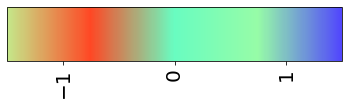

In [197]:
plotColorBar(superop_dict, vertical=True)

In [198]:
superop_dict

{'Basenji': 5,
 'Coyote': 7,
 'East': 6,
 'Greyhound': 8,
 'Hound': 2,
 'Husky': 1,
 'Retriever': 0,
 'Terrier': 4,
 'Tibetan_Mastiff': 9,
 'Wolf': 3}

In [199]:
@timer
def plotAdmixed(granularPopSample, y_predSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_trainTrue=kwargs.get('y_trainTrue')
    superpopsTrue=kwargs.get('superpopsTrue')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    superop_dict=kwargs.get('superop_dict')
    showLegend=kwargs.get('showLegend')
    
    fig, ax = plt.subplots(figsize=(13,11))
    plt.rcParams['hatch.color']='grey'
    
    gs1 = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[13,2])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax1.set_xlim(np.array([-2,2]))
    ax1.set_ylim(np.array([-2,2]))
    ax1.set_zlim(np.array([-2,2])*.77)
    ax2=fig.add_subplot(gs1[1])
    for axis in [ax, ax2]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
#     fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5)
    fig.subplots_adjust(left=-0.5, right=-0.49, bottom=0.0, top=0.4)
    plt.subplots_adjust(hspace=-0.9)
    
    if backgroundAxis:
        colorsPop_sp_dict =plot_all(ax1, y_trainTrue, superpopsTrue, reduce_alpha=1.0, size=100, \
                            superop_dict=superop_dict, cpShow=False)
    else:
        colorsPop_sp_dict = formColorMapBySP(superop_dict)
        
    cmap, norm = getCmap(colorsPop_sp_dict, superop_dict, vertical=True)
    if showLegend:
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
        ax1.add_artist(lgnd)
    alpha=[1]*len(y_predSample)
    
    unknownIdx=np.nonzero(pred_cps)[0]
    print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)/len(y_predSample)}")
    mappedSpArr[unknownIdx]=-1
    colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
    granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
    knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]
        
    # No effect of zorder arg because its a 3d plot and has z axis
    ax1.scatter(y_predSample[knownIdx,0], y_predSample[knownIdx,1], y_predSample[knownIdx,2],\
    c =cmap(norm(y_predSample[knownIdx,2])), cmap=cmap, s=70, zorder=0, edgecolor='black', linewidth=1.)
    
    if cpShow:
        ax1.scatter(y_predSample[unknownIdx,0], y_predSample[unknownIdx,1], y_predSample[unknownIdx,2],\
                    facecolor='grey', hatch=3*'+',\
        color=[tuple(colorsPop_sp_dict[x])+(y,) for x,y in zip(mappedSpArr[unknownIdx] , alpha)], s=50, zorder=0) 
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    
    #chm plot of predictions
    ax2.bar(knownIdx, 1.02*np.ones(len(mappedSpArr[knownIdx])), \
            color=cmap(norm(y_predSample[knownIdx,2])), \
            width=1.0)
    ax2.bar(unknownIdx, 1.02*np.ones(len(mappedSpArr[unknownIdx])), \
        color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], \
        width=1.0, hatch=3*"+")
    
    xtickOffsetBegin=2
    xtickOffsetEnd=-36

    for ax in [ax2]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=30)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, params.n_win)
        ax.set_ylim(0.99,1.09)
        positions = [0+xtickOffsetBegin, int(params.n_win/2), params.n_win+xtickOffsetEnd]
        x_labels = [0, int(params.n_win*params.win_size/2), params.n_win*params.win_size]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
        for tick in ax.xaxis.get_majorticklabels():
            tick.set_horizontalalignment("center")
    
    if kwargs.get('population_description') is not None:
        ax1.set_title(kwargs.get('population_description'), fontsize=50, loc='left')
    plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
#     plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
    plt.show()
    plt.close('all')

In [200]:
# granularPopSample=[sample_name]*params.n_win
# plot_unlabeledSample(granularPopSample, y_predSample, pred_cps=pred_cps_BOC D, mappedSpArr=mappedSpArr, \
# backgroundAxis=True, y_True=y_True, superpopsTrue=superpopsTrue, superop_dict=superop_dict,\
#                      cpShow=False, population_description=population_description)

{'Retriever': 0, 'Husky': 1, 'Hound': 2, 'Wolf': 3, 'Terrier': 4, 'Basenji': 5, 'East': 6, 'Coyote': 7, 'Greyhound': 8, 'Tibetan_Mastiff': 9}
Finished 'plot_all' in 0.2933 secs
number of changepoints removed:114,0.21755725190839695


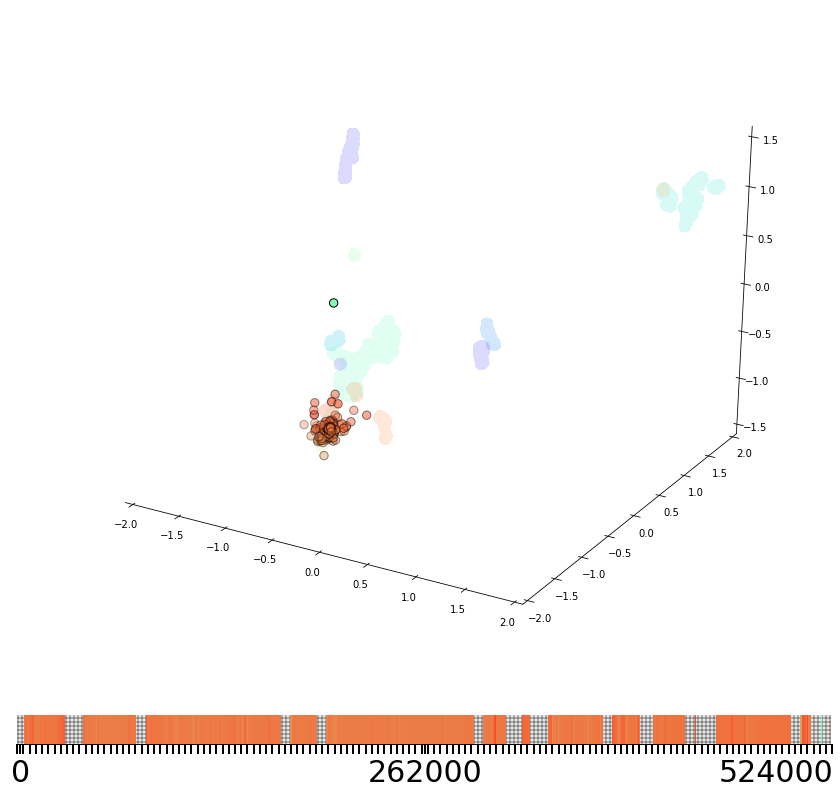

Finished 'plotAdmixed' in 7.1656 secs


In [201]:
granularPopSample=[sample_name]*params.n_win
plotAdmixed(granularPopSample, y_predSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr, \
backgroundAxis=True, y_trainTrue=y_True, superpopsTrue=superpopsTrue, superop_dict=superop_dict,\
cpShow=False, population_description=None, showLegend=False)

In [ ]:
superop_dict